# Second assignment

Li Kailang

FDQAOR

## 0. Download the dataset from kaggle

This dataset contains 300 images of three types of animals: cats, dogs, and foxes. Each category has 100 pictures. The images can help in learning about animals and building computer programs that recognize them. You can use this dataset for school projects, studies in artificial intelligence, or just to learn more about these animals.

In [1]:
from google.colab import drive

# 挂载Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Google Drive中压缩文件的路径
zip_file_path = '/content/drive/MyDrive/Kaggle_dataset/archive.zip'

# 解压到Colab本地目录
colab_dataset_path = '/content/animal_image_dataset'

# 如果解压目标目录存在，先删除它
if os.path.exists(colab_dataset_path):
    import shutil
    shutil.rmtree(colab_dataset_path)

# 解压缩
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(colab_dataset_path)

print(f"数据集已解压到: {colab_dataset_path}")



数据集已解压到: /content/animal_image_dataset


## 1. Build the dataset

In [4]:
from sklearn.model_selection import train_test_split
import shutil

colab_dataset_path = "/content/animal_image_dataset/Animal Image Dataset-Cats, Dogs, and Foxes"

# 创建用于存储训练、验证和测试集的目录
split_dirs = ["train", "val", "test"]

categories = ["cat", "dog", "fox"]

for split in split_dirs:
    for category in categories:
        split_path = os.path.join(colab_dataset_path, split, category)
        os.makedirs(split_path, exist_ok=True)

print("训练集、验证集和测试集目录已创建")

# 划分数据集
for category in categories:
    category_path = os.path.join(colab_dataset_path, category)
    if not os.path.exists(category_path):
        print(f"目录 '{category_path}' 不存在，跳过！")
        continue

    images = os.listdir(category_path)
    if len(images) == 0:
        print(f"目录 '{category_path}' 中没有图片，跳过！")
        continue

    # 使用train_test_split划分数据
    train_val_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=42)
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=0.2, random_state=42)

    # 将文件移动到对应的文件夹
    for img in train_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(colab_dataset_path, "train", category))
    for img in val_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(colab_dataset_path, "val", category))
    for img in test_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(colab_dataset_path, "test", category))

print("数据集划分完成！")


训练集、验证集和测试集目录已创建
数据集划分完成！


## 2. Train model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [13]:
# 数据集路径
train_dir = '/content/animal_image_dataset/Animal Image Dataset-Cats, Dogs, and Foxes/train'
val_dir = '/content/animal_image_dataset/Animal Image Dataset-Cats, Dogs, and Foxes/val'

# 图像尺寸和批量大小
img_height, img_width = 224, 224
batch_size = 32

# 数据增强和加载
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # 将像素值归一化到 [0,1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# 验证集生成器
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 218 images belonging to 3 classes.
Found 57 images belonging to 3 classes.


In [14]:
# 加载预训练模型（MobileNetV2）
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,  # 不包含最后的全连接层
    weights='imagenet'
)

# 冻结预训练模型的权重
base_model.trainable = False

# 构建分类头部
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 三分类问题
])

# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# 定义回调
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# 模型训练
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.5283 - loss: 1.0966 - val_accuracy: 0.9649 - val_loss: 0.2101
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.9336 - loss: 0.2331 - val_accuracy: 0.9649 - val_loss: 0.1576
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.9697 - loss: 0.1011 - val_accuracy: 0.9649 - val_loss: 0.1580
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9803 - loss: 0.0666 - val_accuracy: 0.9474 - val_loss: 0.1755
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9906 - loss: 0.0484 - val_accuracy: 0.9474 - val_loss: 0.1747
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9834 - loss: 0.0589 - val_accuracy: 0.9649 - val_loss: 0.1617
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.9649 - val_loss: 0.1574
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9773 - loss: 0.0560 - val_accuracy: 0.9649 - val_loss: 0.1556
Epoch 9/20
7/7 ━━━

In [25]:
# 加载最佳模型
model = tf.keras.models.load_model('best_model.keras')

# 在验证集上评估
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"val_accuracy: {val_accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9662 - loss: 0.1329
val_accuracy: 0.96


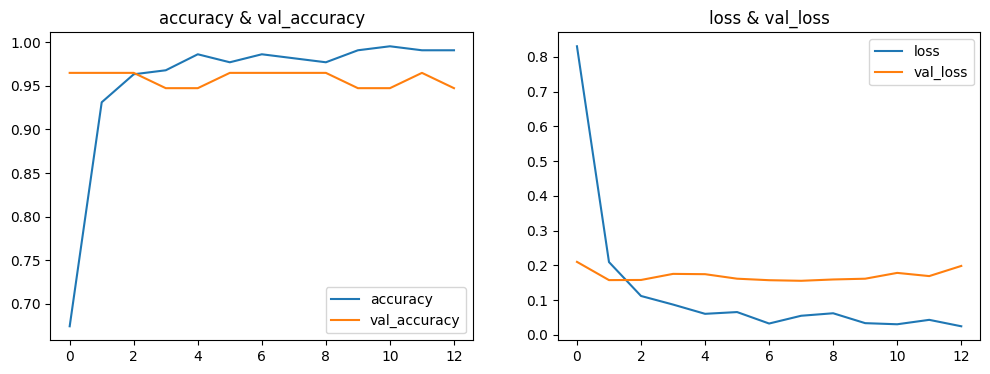

In [24]:
import matplotlib.pyplot as plt

# 绘制训练准确率和损失
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('accuracy & val_accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('loss & val_loss')

plt.show()


## 3. test model by the test data

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 测试数据路径
test_dir = '/content/animal_image_dataset/Animal Image Dataset-Cats, Dogs, and Foxes/test'

# 图像预处理（与训练和验证一致）
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# 测试集生成器
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # 输入尺寸
    batch_size=32,          # 批量大小
    class_mode='categorical',
    shuffle=False           # 确保预测结果与文件名顺序一致
)


Found 33 images belonging to 3 classes.


In [27]:
import numpy as np

# 加载保存的模型
model = tf.keras.models.load_model('best_model.keras')

# 获取真实标签
true_labels = test_generator.classes
class_indices = test_generator.class_indices
classes = list(class_indices.keys())

# 模型预测
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# 计算准确率
accuracy = np.mean(predicted_classes == true_labels)
print(f"test_accuracy: {accuracy:.2%}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
test_accuracy: 90.91%


In [28]:
# 获取文件名
filenames = test_generator.filenames

# 打印文件名、真实类别和预测类别
for i in range(len(filenames)):
    file_name = filenames[i]
    true_class = classes[true_labels[i]]
    predicted_class = classes[predicted_classes[i]]
    print(f"picture: {file_name}, true_label: {true_class}, predicted_class: {predicted_class}")


picture: cat/cat002.jpg, true_label: cat, predicted_class: cat
picture: cat/cat017.jpeg, true_label: cat, predicted_class: fox
picture: cat/cat018.jpeg, true_label: cat, predicted_class: cat
picture: cat/cat034.jpg, true_label: cat, predicted_class: cat
picture: cat/cat037.jpg, true_label: cat, predicted_class: cat
picture: cat/cat044.jpg, true_label: cat, predicted_class: cat
picture: cat/cat052.jpg, true_label: cat, predicted_class: cat
picture: cat/cat062.jpg, true_label: cat, predicted_class: cat
picture: cat/cat072.jpg, true_label: cat, predicted_class: cat
picture: cat/cat085.jpg, true_label: cat, predicted_class: cat
picture: cat/cat095.jpg, true_label: cat, predicted_class: cat
picture: dog/dog002.jpeg, true_label: dog, predicted_class: dog
picture: dog/dog007.jpeg, true_label: dog, predicted_class: fox
picture: dog/dog017.jpg, true_label: dog, predicted_class: dog
picture: dog/dog022.jpg, true_label: dog, predicted_class: dog
picture: dog/dog023.jpg, true_label: dog, predicted